# Лабораторная работа №6

**Студент: Гаптулхаков Р.Р.**

**Группа: М8О-408Б-19**

## Вариант: 3

**Задание**
Используя явную схему крест и неявную схему, решить начально-краевую задачу для дифференциального уравнения гиперболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением U(x, t).

$\large\frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2} - 3u$

$u(0, t) = sin(2t)$

$u(\pi, t) = -sin(2t)$

$u(x, 0) = 0$

$u_t(x, 0) = 2cos(x)$

Аналитическое решение: $U(x, t) = cos(x)sin(2t)$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
def phi_0(t, a=1.0):
    return math.sin(2 * t)

def phi_l(t, a=1.0):
    return -math.sin(2 * t)

def u_0(x):
    return 0

def u(x, t, a=1.0):
    return math.cos(x) * math.sin(2 * t)

def u_0_t(x):
    return 2 * math.cos(x)

def get_tau(sigma, h, a=1.0):
    return np.sqrt(sigma * h**2) 

In [ ]:
def get_ans(sigma, h, a=1.0, l0=0, l1=math.pi, max_T=5.0):
    tau = get_tau(sigma, h)
    x = np.arange(l0, l1 + h, h)
    T = np.arange(0, max_T, tau)
    ans = np.zeros((T.shape[0], len(x)))
    for k, t in enumerate(T): 
        for i, xi in enumerate(x):
            ans[k][i] = u(xi, t)
    return ans

### Явная конечно-разностная схема

В исходном уравнении перейдем от производных к их численным приближениям. Вторую производную будем аппроксимировать по значениям нижнего временного слоя.

Получим рекуррентное соотношение:

$\large u_j^{k+1} = \sigma(u_{j+1}^k-2u_j^k+u_{j-1}^k) + (2 - 3\tau^2)u_j^k - u_j^{k-1}$


где $\large\sigma = \frac{\tau^2}{h^2}$.

Для нижнего временного ряда:

$u_j^0 = \psi_1(x_j)$

$u_j^1 = \psi_1(x_j) + \psi_2(x_j)\tau$

Остальные значения $u$ в нижнем временном ряду известны из начальных условий. Далее можем в цикле проходиться по сетке и рекурретно считать значения в ней по полученной формуле.

*Примечание: можно было повысить порядок аппроксимации для $u_j^1$, но т.к. в моем случае $\psi_1 = 0$, то и вторая производная от нее будет равна нулю, а следовательно повышение порядка бессмысленно*

In [ ]:
def explicit(sigma, h, a=1.0, l0=0, l1=math.pi, max_T=5.0):
    tau = get_tau(sigma, h)
    x = np.arange(l0, l1 + h, h)
    T = np.arange(0, max_T, tau)
    
    X = []
    Y = []
    result = np.zeros((T.shape[0], len(x)))
    
    for i in range(0, len(x)):
        result[0][i] = u_0(x[i])
    X.append(x)
    Y.append([0.0 for _ in x])
    
    for i in range(0, len(x)):
        result[1][i] = u_0(x[i]) + tau * u_0_t(x[i]) 
    X.append(x)
    Y.append([tau for _ in x])
    
    for k in range(2, T.shape[0]):
        result[k][0] = phi_0(T[k])
        result[k][-1] = phi_l(T[k])
        for i in range(1, len(x) - 1):
            result[k][i] = sigma * (result[k - 1][i + 1] - 2 * result[k - 1][i] + result[k - 1][i - 1])   
            result[k][i] -= 3 * tau * tau *  result[k - 1][i]
            result[k][i] += 2 *  result[k - 1][i]
            result[k][i] -= result[k - 2][i]
        X.append(x)
        Y.append([k for _ in x])
    
    return np.array(X), np.array(Y), result

In [ ]:
h = 0.01
sigma = 1
X, Y, Z = explicit(sigma, h, max_T=5.0)

In [ ]:
print(X.shape, Y.shape, Z.shape)

(500, 316) (500, 316) (500, 316)


In [ ]:
h = 0.01
sigma = 1
ans = get_ans(sigma, h)

In [ ]:
(abs(Z - ans) > 10e-4).sum()

0

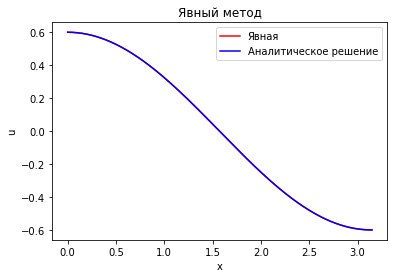

In [ ]:
index = int(np.floor(X.shape[0] / 4))

plt.title("Явный метод")
plt.plot(X[index], Z[index], label="Явная", color = "red")
plt.plot(X[index], ans[index], label="Аналитическое решение", color = "blue")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

### Неявная конечно-разностная схема

В исходном уравнении перейдем от производных к их численным приближениям. Вторую производную будем аппроксимировать по значениям верхнего временного слоя.

Чтобы получить значения $u$ в одном временном ряду, необходимо решить систему уравнений:

$\large\begin{equation*}
 \begin{cases}
   b_1u_1^{k+1}+c_1u_2^{k+1}=d_1, ~~~j=1, 
   \\
   a_ju_{j-1}^{k+1}+b_ju_j^{k+1}+c_ju_{j+1}^{k+1}=d_j, ~~~j=2\dots N-2,
   \\
   a_{N-1}u_{N-2}^{k+1}+b_{N-1}u_{N-1}^{k+1}=d_{N-1}, ~~~j=N-1.
 \end{cases}
\end{equation*}$

$a_j=c_j=\sigma$

$b_j=-(1 + 2\sigma + 3\tau^2)$

$d_j = -2u_j^k + u_j^{k-1}, ~~~j=2\dots N-2$

$d_1=-(u_1^k+\sigma\phi_0(t^{k+1}))$

$d_{N-1}=-(u_{N-1}^k+\sigma\phi_1(t^{k+1}))$


Это трехдиагональная СЛАУ, которую можно решить методом прогонки.

In [ ]:
def race_method(A, b):
    """
    Solves Ax=b
    """
    n = len(A)
    
    v = [0 for _ in range(n)]
    u = [0 for _ in range(n)]
    v[0] = A[0][1] / -A[0][0]
    u[0] = b[0] / A[0][0]
    for i in range(1, n-1):
        v[i] = A[i][i+1] / (-A[i][i] - A[i][i-1] * v[i-1])
        u[i] = (A[i][i-1] * u[i-1] - b[i]) / (-A[i][i] - A[i][i-1] * v[i-1])
    v[n-1] = 0
    u[n-1] = (A[n-1][n-2] * u[n-2] - b[n-1]) / (-A[n-1][n-1] - A[n-1][n-2] * v[n-2])

    x = [0 for _ in range(n)]
    x[n-1] = u[n-1]
    for i in range(n - 1, 0, -1):
        x[i-1] = v[i-1] * x[i] + u[i-1]
    return np.array(x)

In [ ]:
def implicit(sigma, h, a=1.0, l0=0, l1=math.pi, max_T=5.0):
    X = []
    Y = []
    
    tau = get_tau(sigma, h)
    x = np.arange(l0, l1 + h, h)
    T = np.arange(0, max_T, tau)
    
    X.append(x)
    Y.append([0.0 for _ in x])
    
    result = np.zeros((len(T), len(x)))

    for i in range(len(x)):
        result[0][i] = u_0(x[i])
    
    for i in range(len(x)):
        result[1][i] = u_0(x[i]) + tau * u_0_t(x[i])
    
    X.append(x)
    Y.append([tau for _ in x])
    
    a, c = sigma, sigma
    b = -1 - 2 * sigma - 3 * tau * tau

    for k in range(2, T.shape[0]):
        abc_matrix = np.zeros((len(x) - 2, len(x) - 2))
        abc_matrix[0][0] = b
        abc_matrix[0][1] = c
        for i in range(1, len(abc_matrix) - 1):
            abc_matrix[i][i - 1] = a
            abc_matrix[i][i] = b
            abc_matrix[i][i + 1] = c
        abc_matrix[-1][-2] = a
        abc_matrix[-1][-1] = b
        
        d = -2 * result[k - 1][1 : -1] + result[k - 2][1 : -1]
        d[0] -= sigma * phi_0(T[k])
        d[-1] -= sigma * phi_l(T[k])
        result[k][0] = phi_0(T[k])
        result[k][-1] = phi_l(T[k])
        result[k][1:-1] = race_method(abc_matrix, d)
        X.append(x)
        Y.append([k for _ in x])
    return np.array(X), np.array(Y), result

In [ ]:
h = 0.01
sigma = 1
X, Y, Z = implicit(sigma, h)

In [ ]:
X.shape, Y.shape, Z.shape

((500, 316), (500, 316), (500, 316))

In [ ]:
h = 0.01
sigma = 1
ans = get_ans(sigma, h)

In [ ]:
(abs(Z - ans) > 10e-4).sum()

138122

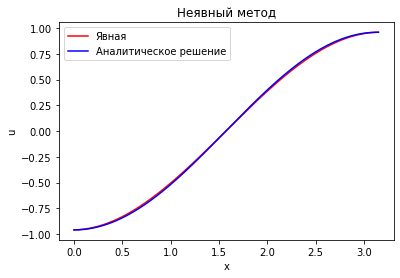

In [ ]:
index = int(np.floor(X.shape[0] / 2))
plt.title("Неявный метод")
plt.plot(X[index], Z[index], label="Явная", color = "red")
plt.plot(X[index], ans[index], label="Аналитическое решение", color = "blue")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Погрешность

In [ ]:
def error(Z, ans):
    return np.absolute(ans - Z).max(axis=1)

In [ ]:
def results(sigma, h, e, label, max_T=5.0):
    tau = get_tau(sigma, h)
    plt.figure(figsize=(15, 9))
    plt.title("Зависимость погрешности с течением времени")
    plt.plot(np.arange(0, max_T, tau), e, label=label, color = "red")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.legend()
    plt.grid()

In [ ]:
h = 0.01
sigma = 1
X1, Y1, Z1 = explicit(sigma, h, max_T=5.0)
ans1 = get_ans(sigma, h, max_T=5.0)
e1 = error(Z1, ans1)

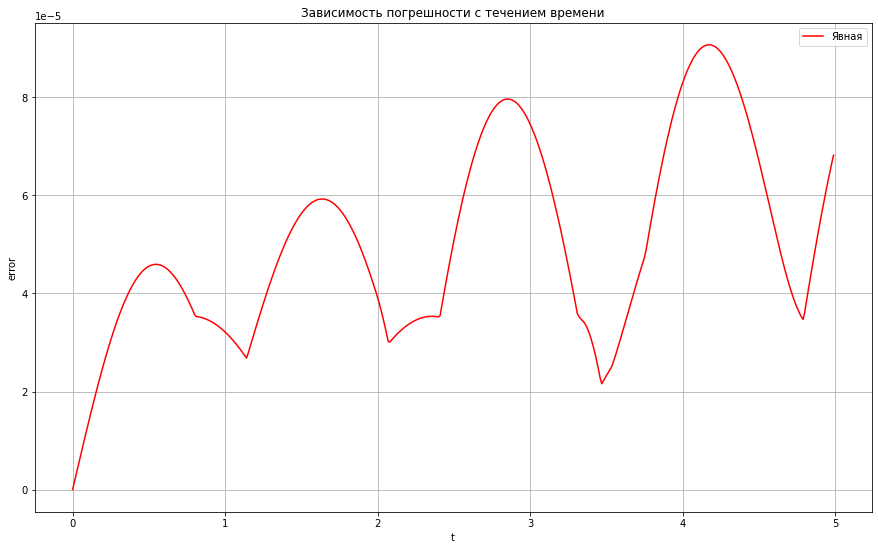

In [ ]:
results(sigma, h, e1, "Явная", max_T=5.0)

In [ ]:
h = 0.01
sigma = 1
X2, Y2, Z2 = implicit(sigma, h, max_T=5.0)
ans2 = get_ans(sigma, h, max_T=5.0)
e2 = error(Z2, ans2)

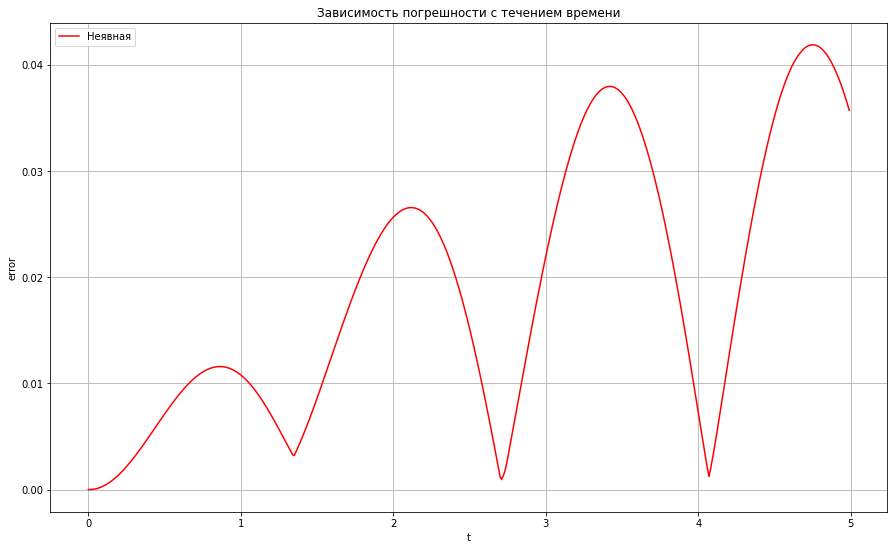

In [ ]:
results(sigma, h, e2, "Неявная", max_T=5.0)

In [ ]:
def common_results(sigma, h, e1, e2, max_T=5.0):
    tau = get_tau(sigma, h)
    plt.figure(figsize=(15, 9))
    plt.title("Зависимость погрешности с течением времени")
  
    plt.plot(np.arange(0, max_T, tau), e1, label="Явная", color = "red")
    plt.plot(np.arange(0, max_T, tau), e2, label="Неявная", color = "blue")
    
    plt.xlabel("t")
    plt.ylabel("error")
    plt.legend()
    plt.grid()

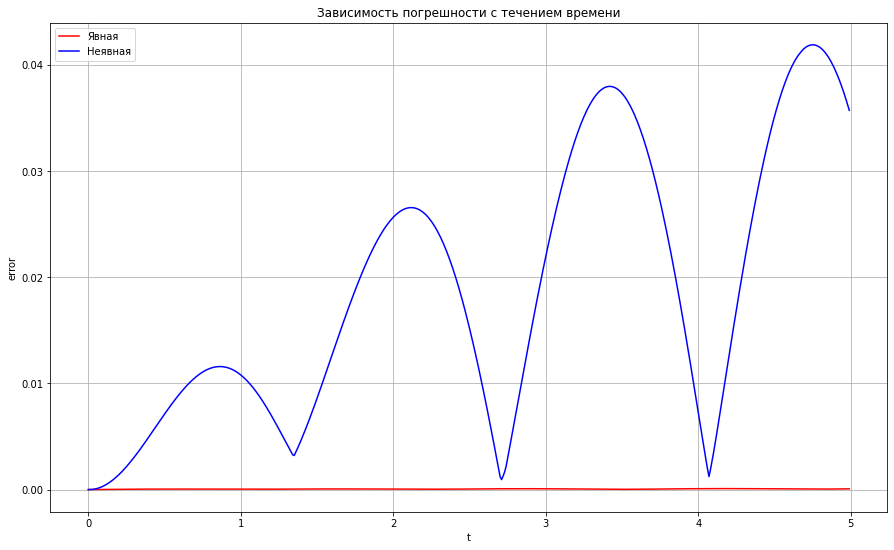

In [ ]:
h = 0.01
sigma = 1
common_results(sigma, h, e1, e2, max_T=5.0)

## Вывод

В данной работе были решены начально-краевые задачи для ДУ гиперболического типа двумя способами. Для решение задачи использовались явный и неявный методы.
Идеи, положительные и отрицательные стороны каждого из методов описаны в прошлой лабораторной.